<a href="https://colab.research.google.com/github/Michael-David-Lam/NLP-Final-Project/blob/main/Experiment_3_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Define General DistilBert Pipline

## Install dependencies

In [1]:
# Install dependencies
!pip install torch torchvision
!pip install transformers
!pip install datasets
!pip install evaluate
# !pip install seqeval

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/b1/43/28bc858b022f6337326d75f4027d2073aad5432328f01ee1236d847f1b82/torchvision-0.22.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/aa/3f/85b56f7e2abcfa558c5fbf7b11eb02d78a4a63e6aeee2bbae3bb552abea5/torch-2.7.0-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.10.0 from https://files.pythonhosted.org/packages/8b/54/b1ae86c0973cc6f0210b53d508ca3641fb6d0c56823f288d108bc7ab3cc8/typing_extensions-4.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for sympy>=1.13.3 from https://files.pythonhosted.org/packages/a2/09/77d55d46fd61b4a135c444fc97158ef34a095e5681d0a6c10b75bf356191/sympy-1.14.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68

  Obtaining dependency information for evaluate from https://files.pythonhosted.org/packages/a2/e7/cbca9e2d2590eb9b5aa8f7ebabe1beb1498f9462d2ecede5c9fd9735faaf/evaluate-0.4.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.5 MB/s eta 0:00:00


## Load packages and dataset

In [2]:
# Load packages
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import load_dataset
import evaluate

/Users/darren/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
# Load dataset
dataset = load_dataset("surrey-nlp/PLOD-CW-25")
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})

In [4]:
dataset['train'][0]

{'tokens': ['MRR',
  ',',
  'mortality',
  'rate',
  'ratio',
  ';',
  'TBI',
  ',',
  'traumatic',
  'brain',
  'injury',
  '.'],
 'pos_tags': ['NOUN',
  'PUNCT',
  'NOUN',
  'NOUN',
  'NOUN',
  'PUNCT',
  'PROPN',
  'PUNCT',
  'ADJ',
  'NOUN',
  'NOUN',
  'PUNCT'],
 'ner_tags': ['B-AC',
  'O',
  'B-LF',
  'I-LF',
  'I-LF',
  'O',
  'B-AC',
  'O',
  'B-LF',
  'I-LF',
  'I-LF',
  'O']}

## Define Model & Tokenizer
### Tokenize data

In [5]:
# define model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
model = AutoModelForTokenClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=4   # Class labels: B-AC, B-LF, I-LF, O
)

# this fucntion is to tokenize our dataset
def tokenize_and_align_labels(batch):
    tokenized = tokenizer(
        batch["tokens"],
        truncation=True,
        padding="max_length",
        max_length=128,
        is_split_into_words=True
    )

    labels = batch["ner_tags"]
    label_to_id = {"B-AC": 0, "B-LF": 1, "I-LF": 2, "O": 3}
    aligned_labels = []

    for i, label in enumerate(labels):
        word_ids = tokenized.word_ids(i)
        aligned_label = []
        for word_idx in word_ids:
            if word_idx is None:
                aligned_label.append(-100)  # for padding or special tokens
            else:
                aligned_label.append(label_to_id.get( label[min(word_idx, len(label) - 1)], -100 ))
        aligned_labels.append(aligned_label)

    tokenized["labels"] = aligned_labels
    return tokenized
# create tokenized dataset
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

/Users/darren/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

##Define F1 Metric function

In [6]:
metric = evaluate.load("f1")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    true_labels, true_preds = [], []
    for pred_row, label_row in zip(preds, labels):
        for p, l in zip(pred_row, label_row):
            if l != -100:  # ignore padding
                true_labels.append(l)
                true_preds.append(p)

    return metric.compute(predictions=true_preds, references=true_labels, average="weighted")

##Training Arguments

In [8]:
# define general training args
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_strategy ="epoch",
    report_to="none",
)

## Define Loss Function

In [15]:
import torch
from torch.nn import CrossEntropyLoss

# Mannually define class weights
# [B-AC, B-LF, I-LF, O]
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
class_weights = torch.tensor([1.0, 2.0, 2.0, 0.5]).to(device)


# define custom trainer subclass to override loss default funtion
class CustomTrainer(Trainer):
    # Custom loss function - weighted CrossEntropyLoss
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits
        labels = inputs["labels"]

        # Flatten the logits and labels to match shape for CrossEntropyLoss
        logits = logits.view(-1, model.config.num_labels)
        labels = labels.view(-1)

        # Apply CrossEntropyLoss with class weights
        loss_fn = CrossEntropyLoss(weight=class_weights, ignore_index=-100)
        loss = loss_fn(logits, labels)

        if return_outputs:
            return loss, outputs
        else:
            return loss

# Experiment Setup-1
Optimizer = Adam

In [16]:
from torch.optim import Adam, AdamW

# Define optimizers
optimizer1 = Adam(model.parameters(), lr=1e-5)
optimizer2 = AdamW(model.parameters(), lr=1e-5)

### Default Trainer Class:
 * Loss Function - Cross Entropy Loss
 * Optimizer - Adam

In [17]:
# Init default trainer - Cross Entropy loss, Adam Optimizer
trainer1_cross = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    optimizers=(optimizer1, None) #custom optimizer
)
trainer1_cross.train()

Epoch,Training Loss,Validation Loss,F1
1,0.207700,0.344640,0.883464
2,0.173200,0.371447,0.886318
3,0.152300,0.370267,0.885989
4,0.138000,0.405466,0.885287
5,0.133700,0.406166,0.884736


/Users/darren/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/darren/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/darren/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/darren/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1250, training_loss=0.16100890197753906, metrics={'train_runtime': 159.5589, 'train_samples_per_second': 62.673, 'train_steps_per_second': 7.834, 'total_flos': 326644561920000.0, 'train_loss': 0.16100890197753906, 'epoch': 5.0})

In [18]:
trainer1_cross.evaluate(eval_dataset=tokenized_dataset["test"])

/Users/darren/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.2529791295528412,
 'eval_f1': 0.9112280810058805,
 'eval_runtime': 1.2522,
 'eval_samples_per_second': 199.652,
 'eval_steps_per_second': 25.555,
 'epoch': 5.0}

### Custom Trainer Class:
  * Loss Function - Weighted Cross Entropy Loss
  * Optimizer - Adam

In [19]:
# Init custom trainer - Weighted Cross Entropy loss, Adam Optimizer
trainer1_crossW = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    optimizers=(optimizer1, None) #custom optimizer
)
trainer1_crossW.train()

/Users/darren/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(
/Users/darren/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,F1
1,0.146600,0.470217,0.884944
2,0.118600,0.517752,0.882800
3,0.118800,0.508401,0.886745
4,0.104700,0.531082,0.886791
5,0.099800,0.536805,0.885329


/Users/darren/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/darren/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/darren/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/darren/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1250, training_loss=0.1176938735961914, metrics={'train_runtime': 202.5477, 'train_samples_per_second': 49.371, 'train_steps_per_second': 6.171, 'total_flos': 326644561920000.0, 'train_loss': 0.1176938735961914, 'epoch': 5.0})

In [20]:
trainer1_crossW.evaluate(eval_dataset=tokenized_dataset["test"])

/Users/darren/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.3452511727809906,
 'eval_f1': 0.9125447918881725,
 'eval_runtime': 1.9606,
 'eval_samples_per_second': 127.515,
 'eval_steps_per_second': 16.322,
 'epoch': 5.0}

In [21]:
from seqeval.metrics import classification_report
import numpy as np

predictions, labels, _ = trainer1_crossW.predict(tokenized_dataset["validation"])

label_list = ["O", "B-AC", "B-LF", "I-LF"] 

preds = np.argmax(predictions, axis=-1)

true_labels = []
true_predictions = []

for pred_seq, label_seq in zip(preds, labels):
    true_label_seq = []
    pred_label_seq = []
    for pred, label in zip(pred_seq, label_seq):
        if label != -100:  # ignore padding tokens
            true_label_seq.append(label_list[label])
            pred_label_seq.append(label_list[pred])
    true_labels.append(true_label_seq)
    true_predictions.append(pred_label_seq)

print(classification_report(true_labels, true_predictions))


/Users/darren/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

          AC       0.70      0.85      0.77       587
          LF       0.69      0.81      0.75      1581

   micro avg       0.69      0.82      0.75      2168
   macro avg       0.70      0.83      0.76      2168
weighted avg       0.69      0.82      0.75      2168



/Users/darren/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

          AC       0.70      0.85      0.77       587
          LF       0.69      0.81      0.75      1581

   micro avg       0.69      0.82      0.75      2168
   macro avg       0.70      0.83      0.76      2168
weighted avg       0.69      0.82      0.75      2168



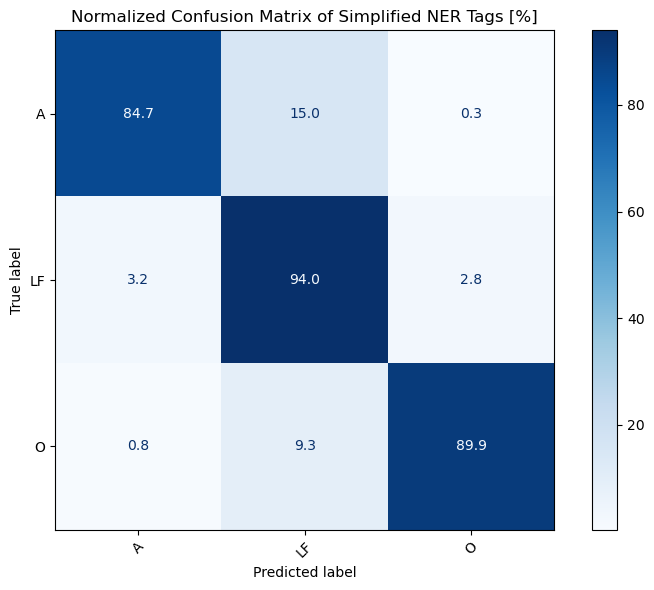

In [23]:
from seqeval.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

predictions, labels, _ = trainer1_crossW.predict(tokenized_dataset["validation"])
label_list = ["O", "B-AC", "B-LF", "I-LF"]
preds = np.argmax(predictions, axis=-1)

true_labels = []
true_predictions = []

for pred_seq, label_seq in zip(preds, labels):
    true_seq = []
    pred_seq_clean = []
    for p, l in zip(pred_seq, label_seq):
        if l != -100:
            true_seq.append(label_list[l])
            pred_seq_clean.append(label_list[p])
    true_labels.append(true_seq)
    true_predictions.append(pred_seq_clean)

print(classification_report(true_labels, true_predictions))

flat_true = [tag for seq in true_labels for tag in seq]
flat_pred = [tag for seq in true_predictions for tag in seq]

def simplify(tag):
    if tag == "B-AC":
        return "A"
    elif tag in ("B-LF", "I-LF"):
        return "LF"
    else:
        return "O"

flat_true_simplified = [simplify(tag) for tag in flat_true]
flat_pred_simplified = [simplify(tag) for tag in flat_pred]

le = LabelEncoder()
le.fit(["A", "LF", "O"])
y_true_encoded = le.transform(flat_true_simplified)
y_pred_encoded = le.transform(flat_pred_simplified)

cm = confusion_matrix(y_true_encoded, y_pred_encoded, normalize='true') * 100

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=ax, values_format=".1f", xticks_rotation=45)
plt.title("Normalized Confusion Matrix of Simplified NER Tags [%]")
plt.tight_layout()
plt.show()

# Experiment Setup-2
Optimizer = AdamW

### Default Trainer Class:
  * Loss Function - Cross Entropy Loss
  * Optimizer - AdamW

In [57]:
# Init second default trainer - Cross Entropy loss, AdamW Optimizer
trainer2_cross = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    optimizers=(optimizer2, None) #custom optimizer
)
trainer2_cross.train()

Epoch,Training Loss,Validation Loss,F1
1,0.138700,0.428351,0.886464
2,0.113600,0.469192,0.885303
3,0.100900,0.453622,0.882394
4,0.097900,0.457666,0.886917
5,0.092500,0.463837,0.884596


TrainOutput(global_step=1250, training_loss=0.10869351501464844, metrics={'train_runtime': 154.5043, 'train_samples_per_second': 64.723, 'train_steps_per_second': 8.09, 'total_flos': 326644561920000.0, 'train_loss': 0.10869351501464844, 'epoch': 5.0})

In [58]:
trainer2_cross.evaluate(eval_dataset=tokenized_dataset["test"])

{'eval_loss': 0.31509044766426086,
 'eval_f1': 0.9048358952897892,
 'eval_runtime': 1.0179,
 'eval_samples_per_second': 245.608,
 'eval_steps_per_second': 31.438,
 'epoch': 5.0}

### Custom Trainer Class:
  * Loss Function - Weighted Cross Entropy Loss
  * Optimizer - AdamW

In [59]:
# Init second custom trainer - Weighted Cross Entropy loss, AdamW Optimizer
trainer2_crossW = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    optimizers=(optimizer2, None) #custom optimizer
)
trainer2_crossW.train()

Epoch,Training Loss,Validation Loss,F1
1,0.073400,0.657009,0.885023
2,0.057700,0.662524,0.886114
3,0.050900,0.703807,0.885237
4,0.053000,0.689678,0.884397
5,0.061600,0.676018,0.884780


TrainOutput(global_step=1250, training_loss=0.059328802490234374, metrics={'train_runtime': 153.1119, 'train_samples_per_second': 65.312, 'train_steps_per_second': 8.164, 'total_flos': 326644561920000.0, 'train_loss': 0.059328802490234374, 'epoch': 5.0})

In [60]:
trainer2_crossW.evaluate(eval_dataset=tokenized_dataset["test"])

{'eval_loss': 0.4350109398365021,
 'eval_f1': 0.910539946631976,
 'eval_runtime': 1.0774,
 'eval_samples_per_second': 232.05,
 'eval_steps_per_second': 29.702,
 'epoch': 5.0}

#Visualization

In [61]:
#add code